In [75]:
import numpy as np
import pandas as pd
from numba import njit

from math import log, sqrt, pi, exp
from scipy.stats import norm

from matplotlib import pyplot as plt
from tqdm import tqdm
from time import perf_counter
import gc

# Binomial Tree

In [61]:
def buildTree(S, vol , T, N):
    dt = T / N
    matrix = np.zeros((N + 1, N + 1))
    u = np.e **  (vol * np.sqrt(dt)) # TODO
    d = np.e ** (-vol * np.sqrt(dt)) # TODO

    # Iterate over the lower triangle
    for i in np.arange(N + 1): # iterate over rows
        for j in np.arange(i + 1): # iterate over columns
            # Hint: express each cell as a combination of up and down moves
            matrix[i, j] = S * d ** (i-j) * u ** (j)

    return matrix

In [62]:
sigma = 0.1
S = 80
T =1.
N = 2

print(buildTree(S, sigma, T, N))

[[80.          0.          0.        ]
 [74.53851387 85.86165282  0.        ]
 [69.44987563 80.         92.15279281]]


## Full Binomial Tree

In [81]:
@njit
def call_bt(T, r , K, vol, N, S ):
    dt = T / N
    u = np.exp(vol * np.sqrt(dt)) # TODO
    d = np.exp(-vol * np.sqrt(dt)) # TODO
    p = (np.exp(r*dt) - d)/(u - d) # TODO
    """ ----- Build the Tree ----- """
    tree = np.zeros((N + 1, N + 1))
    # Iterate over the lower triangle
    for i in np.arange(N + 1): # iterate over rows
        for j in np.arange(i + 1): # iterate over columns
            # Hint: express each cell as a combination of up and down moves
            tree[i, j] = S * d ** (i-j) * u ** (j) # TODO

    """ ----- Calculate the Option Value ----- """
    columns = tree.shape[1]
    rows = tree.shape[0]

    # Walk backward , we start in last row of the matrix

    # Add the payoff function in the last row
    for c in np.arange(columns):
        _S = tree[rows-1, c] # value in the matrix
        tree[rows-1, c] = max(0, _S - K) # TODO
    # print( tree )

    # For all other rows , we need to combine from previous rows
    # We walk backwards , from the last row to the first row
    for i in np.arange(rows-1)[::-1]:
        for j in np.arange(i + 1):
            down = tree[i+1, j]
            up = tree[i + 1, j + 1]
            tree[i , j ] = (np.exp(-r*dt)) * (p * up + (1 - p) * down) # TODO
    V = tree[0,0]
    """ Greeks """
    D = (tree[1, 1] - tree[1, 0])/(S * (u - d))
    return V, D

In [82]:
sigma = 0.2
S = 100
T=1.
N=10_000

K = 99
r = 0.06

# tree = buildTree(S, sigma, T, N)
V_bt, D_bt = call_bt(T, r , K, sigma, N, S)
print(f'Option Value with N({N}) steps = {V_bt:.5f}')
print(f'Delta with N({N}) steps        = {D_bt:.5f}')
# option_value_tree

Option Value with N(10000) steps = 11.54445
Delta with N(10000) steps        = 0.67373


# Black-Scholes Formula

In [83]:
def bs_call(S,K,T,r,sigma):
    d1 = (log(S/K)+(r+sigma**2/2.)*T)/(sigma*sqrt(T))
    d2 = d1 - sigma*sqrt(T)

    V = S*norm.cdf(d1) -K*exp(-r*T)*norm.cdf(d2)
    D = norm.cdf(d1)

    return V, D

In [84]:
sigma = 0.2
S = 100
T=1.

K = 99
r = 0.06
bs_result, bs_D = bs_call(S,K,T,r,sigma)
print(f'Option Value with Black-Scholes Formula = {bs_result}')
print(f'Delta Value with Black-Scholes Formula = {bs_D}')

Option Value with Black-Scholes Formula = 11.544280227051097
Delta Value with Black-Scholes Formula = 0.6737355117348961


# Tests
## Option Value Convergence with n

In [85]:

T=1.
r = 0.06
K = 99
sigma = 0.2
S = 100

NN = np.log2(10_000) ;   size = 50   ;
values = np.zeros((size, 3))
for n in tqdm(np.append(np.logspace(1, NN, size, base=2, dtype=int), 50)): #  _starting_n, NN)):
    # print(n)
    _st = perf_counter()
    V_bt, _ = call_bt(T, r, K, sigma, n, S)
    values[size-1] = [n, V_bt, perf_counter() - _st]
    size -= 1
values = values[::-1]

100%|██████████| 51/51 [00:02<00:00, 20.68it/s] 


Option Value with N(9999) = 11.54410 EUR
Option Value with N(50)   = 11.54643 EUR
Difference with (9999)    = -0.00233 EUR
Option Value Black-Scholes Formula = 11.54428 EUR


,Binary_Tree,Execution_Time,Black_Scholes
2.0,10.842582,1.750013e-06,11.54428
2.0,10.842582,8.330098e-07,11.54428
3.0,12.105041,4.750036e-06,11.54428
4.0,11.221167,6.938750e-03,11.54428
4.0,11.221167,1.058297e-05,11.54428
5.0,11.877161,1.091702e-05,11.54428
6.0,11.349620,1.491699e-05,11.54428
8.0,11.412268,3.041991e-06,11.54428
9.0,11.724538,2.375047e-06,11.54428
11.0,11.689917,1.050002e-05,11.54428


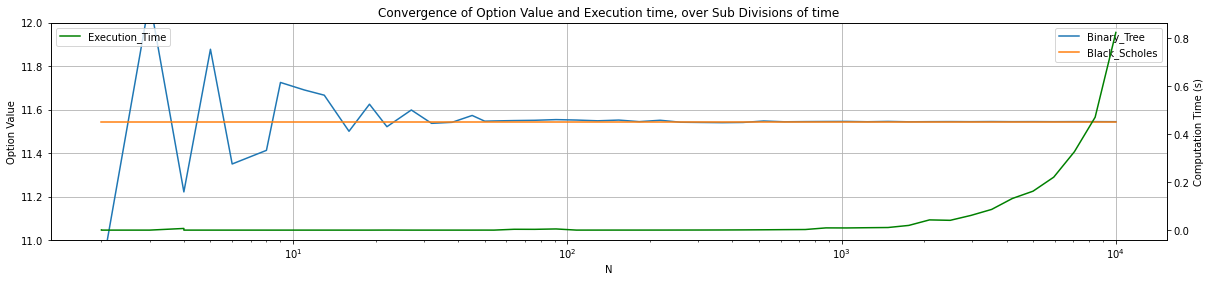

In [86]:
_results_df = pd.DataFrame(values[:, 1:], columns=['Binary_Tree', 'Execution_Time'] , index=values[:, 0]).sort_index()
_results_df["Black_Scholes"] = bs_result
_results_df

fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()

_results_df[['Binary_Tree', 'Black_Scholes']].plot(figsize=(20,4), ylim=(11,12), ax=ax_left, xlabel='N', ylabel='Option Value', legend='Option Value - USD',
                              title='Convergence of Option Value and Execution time, over Sub Divisions of time', grid=True, logx=True)
_results_df.Execution_Time.plot(ax=ax_right, color='green', ylabel='Computation Time (s)', legend='Computation Time')

print(f'Option Value with N({int(2**NN)}) = {_results_df.iloc[-1].Binary_Tree:.5f} EUR')
print(f'Option Value with N(50)   = {_results_df[_results_df.index == 50.0].Binary_Tree.values[0]:.5f} EUR')
print(f'Difference with ({int(2**NN)})    = {_results_df.iloc[-1].Binary_Tree - _results_df[_results_df.index == 50.0].Binary_Tree.values[0]:.5f} EUR')
print(f'Option Value Black-Scholes Formula = {_results_df.iloc[-1].Black_Scholes:.5f} EUR')
# print(f'% Difference = {(_results_df.iloc[-1].Option_Value - _results_df[_results_df.index == 50.0].Option_Value.values[0]) / _results_df[_results_df.index == 50.0].Option_Value.values[0] * 100}')
_results_df

## Option Value accuracy for different Levels of Volatility

In [10]:
V_df = np.zeros((50,0))
D_df = np.zeros((50,0))
Inx_df = np.zeros((50,0))

_S = 100    ; _T = 1.   ; _K = 99   ; _r = 0.06

volatility = [10., 5., 1., .5, .1, .05]
for inx, vol in enumerate(volatility):
    V_bs, D_bs = bs_call(_S, _K, _T, _r, vol)

    _N = np.log2(100) ;   size = 50
    values = np.zeros((size, 3))
    for n in tqdm(np.append(np.logspace(1, _N, size, base=2, dtype=int), 50)): #  _starting_n, NN)):
        V_bt, D_bt = call_bt(_T, _r, _K, vol, n, _S)

        V_diff = (V_bt - V_bs)/V_bs * 100
        D_diff = (D_bt - D_bs)/D_bs * 100

        values[size-1] = [n, V_diff, D_diff]    ;   size -= 1
    # values = values[::-1]

    V_df = (np.insert(V_df, inx, values[:,1], axis=1))
    D_df = (np.insert(D_df, inx, values[:,2], axis=1))

columns = [f'σ {v}' for v in volatility]
V_df = pd.DataFrame(V_df, index=values[:,0], columns=columns).drop_duplicates().sort_index()
D_df = pd.DataFrame(D_df, index=values[:,0], columns=columns).drop_duplicates().sort_index()
V_df
# values_df.sort_index(inplace=True)
# values_df

100%|██████████| 51/51 [00:00<00:00, 94608.36it/s]


,σ 10.0,σ 5.0,σ 1.0,σ 0.5,σ 0.1,σ 0.05
2.0,-0.163003,-4.294319,-9.853122,-8.649692,-4.017578,-2.060112
3.0,-0.005498,-0.364255,6.490177,6.718843,2.014428,-0.590886
4.0,-0.025652,-1.975455,-5.081738,-4.340992,-1.657787,-0.921635
5.0,-0.002680,-0.300917,3.883853,4.008302,1.182492,-0.315301
6.0,-0.008496,-1.255810,-3.379828,-2.823391,-0.893034,-0.513132
7.0,-0.001534,-0.244843,2.765556,2.848853,0.801207,-0.259406
8.0,-0.003983,-0.914683,-2.514319,-2.059443,-0.535779,-0.322242
9.0,-0.000995,-0.204322,2.145762,2.206993,0.584318,-0.242441
10.0,-0.002276,-0.717453,-1.992381,-1.602826,-0.336838,-0.217633
11.0,-0.000704,-0.174690,1.752280,1.799739,0.444696,-0.236492


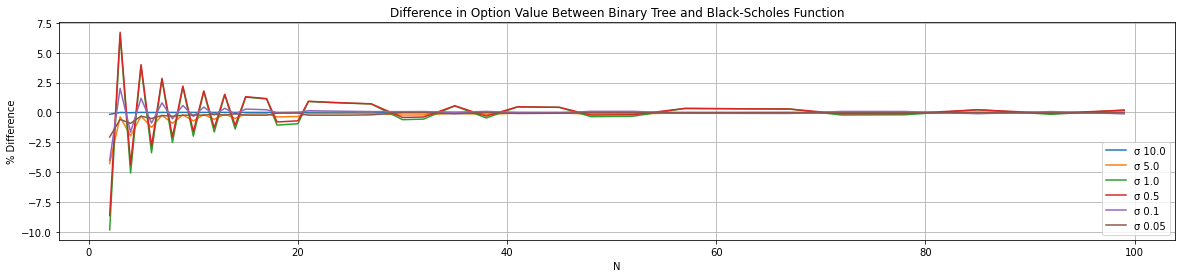

In [11]:
V_df.plot(figsize=(20,4), xlabel='N', ylabel='% Difference', legend='Option Value - USD',
                              title='Difference in Option Value Between Binary Tree and Black-Scholes Function', grid=True, logx=False)
inx = [50.0]
# values_df[values_df.where(values_df.index == 50.0)]
# values_df[(values_df.index == 50.0)]

<AxesSubplot:title={'center':'Difference in Option Delta Between Binary Tree and Black-Scholes Function'}, xlabel='N', ylabel='% Difference'>

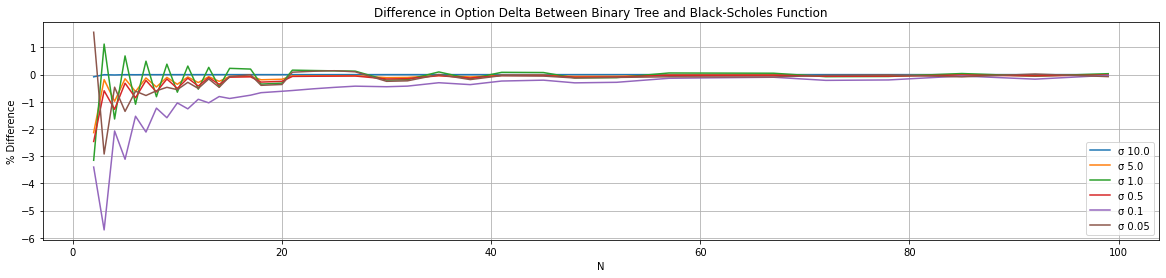

In [12]:
D_df.plot(figsize=(20,4), xlabel='N', ylabel='% Difference', legend='Option Value - USD',
                              title='Difference in Option Delta Between Binary Tree and Black-Scholes Function', grid=True, logx=False)

<AxesSubplot:title={'center':'% Difference Between Binomial Tree (50) and Black-Scholes Formula'}, xlabel='Volatility (σ)', ylabel='% Difference'>

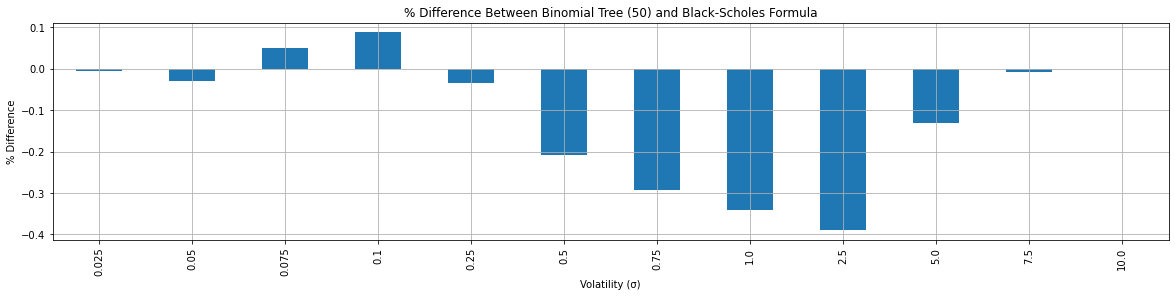

In [13]:
values_df = pd.DataFrame()
_S = 100    ;    _T=1. ; _K = 99   ;   _r = 0.06

space = []
for fp in [10, 1, .1, .01]:
    _divisions = 4
    for sd in [(x+1)/_divisions for x in range(_divisions)]:
        space.append(fp*sd)
# print(space)

N = 50 ;   size = len(space)-4
values = np.zeros((size, 2))
for vol in space[:-4]:
    V_bt, D_bt = call_bt(_T, _r, _K, vol, N, _S)
    V_bs, D_bs = bs_call(_S, _K, _T, _r, vol)
    values[size-1] = [f"{vol:.3f}", (V_bt - V_bs)/V_bs*100]
    size -= 1

# pd.set_eng_float_format(accuracy=3)
values = pd.DataFrame(values[::-1][:,1], index=values[::-1][:,0], columns=['% Difference'])
values.sort_index(inplace=True)
values.plot(kind='bar', figsize=(20,4), grid=True, title="% Difference Between Binomial Tree (50) and Black-Scholes Formula",
            ylabel='% Difference', xlabel='Volatility (σ)', legend=False)
# values

<AxesSubplot:title={'center':'% Difference in Delta Between Binomial Tree (50) and Black-Scholes Formula'}, xlabel='Volatility (σ)', ylabel='% Difference'>

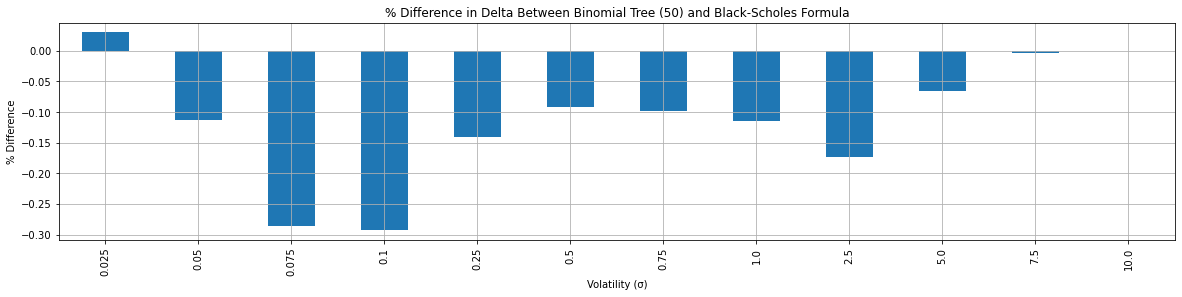

In [14]:
values_df = pd.DataFrame()
_S = 100    ;    _T = 1. ; _K = 99   ;   _r = 0.06

space = []
for fp in [10, 1, .1, .01]:
    _divisions = 4
    for sd in [(x+1)/_divisions for x in range(_divisions)]:
        space.append(fp*sd)
# print(space)

N = 50 ;   size = len(space)-4
values = np.zeros((size, 2))
for vol in space[:-4]:
    V_bt, D_bt = call_bt(_T, _r, _K, vol, N, _S)
    V_bs, D_bs = bs_call(_S, _K, _T, _r, vol)
    values[size-1] = [f"{vol:.3f}", (D_bt - D_bs)/D_bs*100]
    size -= 1

# pd.set_eng_float_format(accuracy=3)
values = pd.DataFrame(values[::-1][:,1], index=values[::-1][:,0], columns=['% Difference'])
values.sort_index(inplace=True)
values.plot(kind='bar', figsize=(20,4), grid=True, title="% Difference in Delta Between Binomial Tree (50) and Black-Scholes Formula",
            ylabel='% Difference', xlabel='Volatility (σ)', legend=False)
# values

--------------------------------------------------------------------------------------------------------------------------------------------
# American options

In [76]:
@njit
def option_contract_bt(T, r , K, vol, N, S ,type="C", american=False):
    dt = T / N
    u = np.exp(vol * np.sqrt(dt)) # TODO
    d = np.exp(-vol * np.sqrt(dt)) # TODO
    p = (np.exp(r*dt) - d)/(u - d) # TODO
    """ ----- Build the Tree ----- """
    tree = np.zeros((N + 1, N + 1))
    # Iterate over the lower triangle
    for i in np.arange(N + 1): # iterate over rows
        for j in np.arange(i + 1): # iterate over columns
            # Hint: express each cell as a combination of up and down moves
            # tree[i, j] = max(tree[i, j], S * d ** (i-j) * u ** (j)) # TODO
            tree[i, j] = S * d ** (i-j) * u ** (j) # TODO

    """ ----- Calculate the Option Value ----- """
    columns = tree.shape[1]
    rows = tree.shape[0]

    # Walk backward , we start in last row of the matrix

    # Add the payoff function in the last row
    for c in np.arange(columns):
        _S = tree[rows-1, c] # value in the matrix
        if type == "C": tree[rows-1, c] = max(0, _S - K) # TODO
        else: tree[rows-1, c] = max(0, K- _S) # TODO
    # print( tree.astype(int) )

    # For all other rows , we need to combine from previous rows
    # We walk backwards , from the last row to the first row
    for i in np.arange(rows-1)[::-1]:
        for j in np.arange(i + 1):
            down = tree[i+1, j]
            up = tree[i + 1, j + 1]
            if type == "C":
                if american:    tree[i , j ] = max(tree[i , j ]-K, (np.exp(-r*dt)) * (p * up + (1 - p) * down)) # TODO
                else:   tree[i , j ] = (np.exp(-r*dt)) * (p * up + (1 - p) * down) # TODO
            else:
                if american:    tree[i , j ] = max(K-tree[i , j ], (np.exp(-r*dt)) * (p * up + (1 - p) * down)) # TODO
                else:   tree[i , j ] = (np.exp(-r*dt)) * (p * up + (1 - p) * down) # TODO
    # print(tree)
    V = tree[0,0]
    """ Greeks """
    D = (tree[1, 1] - tree[1, 0])/(S * (u - d))
    return V, D

In [77]:
sigma = 0.2
S = 100
T=1.
N=10000

K = 99
r = 0.06

# tree = buildTree(S, sigma, T, N)
V_bt, D_bt = option_contract_bt(T, r , K, sigma, N, S, type="P", american=True)
print(f'Option Value with N({N}) steps = {V_bt:.5f}')
print(f'Delta with N({N}) steps        = {D_bt:.5f}')

OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Option Value with N(10000) steps = 5.34822
Delta with N(10000) steps        = -0.38114


## Difference between European and American Options for different levels of volatility

[2.5, 5.0, 7.5, 10.0, 0.25, 0.5, 0.75, 1.0, 0.025, 0.05, 0.07500000000000001, 0.1]


100%|██████████| 12/12 [00:02<00:00,  5.12it/s]

\begin{tabular}{lrrr}
\toprule
{} &  American &  European &  \% Difference \\
\midrule
10.000 &  98.07811 &  93.23463 &       5.19494 \\
7.500  &  97.48155 &  93.21726 &       4.57457 \\
5.000  &  95.10695 &  92.02959 &       3.34388 \\
2.500  &  74.30509 &  72.82528 &       2.03200 \\
1.000  &  34.47351 &  33.69776 &       2.30210 \\
0.750  &  25.67885 &  24.98169 &       2.79067 \\
0.500  &  16.51082 &  15.87699 &       3.99212 \\
0.250  &   7.18674 &   6.60304 &       8.83981 \\
0.100  &   1.85049 &   1.37793 &      34.29472 \\
0.075  &   1.07552 &   0.68244 &      57.59994 \\
0.050  &   0.41627 &   0.17639 &     135.99121 \\
0.025  &   0.02701 &   0.00180 &    1396.99448 \\
\bottomrule
\end{tabular}



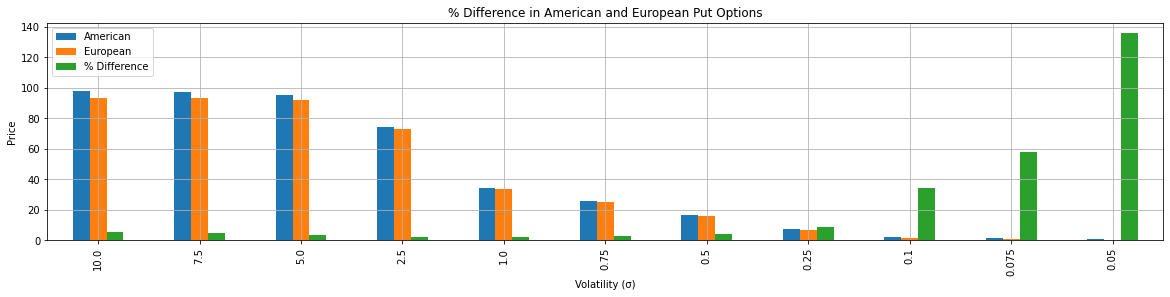

In [100]:
values_df = pd.DataFrame()
_S = 100    ;    _T = 1. ; _K = 99   ;   _r = 0.06

space = []
for fp in [10, 1, .1]:
    _divisions = 4
    for sd in [(x+1)/_divisions for x in range(_divisions)]:
        space.append(fp*sd)
print(space)

N = 1_000 ;   size = len(space)
values = np.zeros((size, 4))
for vol in tqdm(space):
    american_put_option_value, _ = option_contract_bt(T, r , K, vol, N, S, type="P", american=True)
    european_put_option_value, _ = option_contract_bt(T, r , K, vol, N, S, type="P", american=False)
    values[size-1] = [f"{vol:.3f}", american_put_option_value, european_put_option_value, (american_put_option_value - european_put_option_value)/european_put_option_value*100]
    size -= 1

values = pd.DataFrame(values[::-1][:,1:], index=values[::-1][:,0], columns=['American','European', '% Difference'])
values.sort_index(inplace=True, ascending=False)
values.iloc[:-1,:].plot(kind='bar', figsize=(20,4), grid=True, title="% Difference in American and European Put Options",
            ylabel='Price', xlabel='Volatility (σ)', legend=True)
print(values.to_latex(float_format='%.5f'))

In [ ]:
# Play around with different ranges of N and step sizes .
N = np.arange(1,300)

# Calculate the option price for the correct parameters
optionPriceAnalytical = 0 # TODO

# calculate option price for each n in N
for n in N:
    treeN = buildTree (...) # TODO
    priceApproximatedly = valueOption ( . . . ) # TODO

# use matplotlib to plot the analytical value
# and the approximated value for each n